In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
#import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
#from apex import amp
import sys

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/'

In [6]:
import os

In [7]:
#https://drive.google.com/drive/folders/1nfQZe8OYJNzGYfV8D3bprSzmFQoSkuaN?usp=drive_link
directory = '/content/drive/MyDrive/Colab_Notebooks/fish'
train_files = []
target_files = []
fish_types = 'Black Sea Sprat'
for file in os.listdir(os.path.join(directory, fish_types)):
    train_files.append(os.path.join(directory, 'Black Sea Sprat', file))
    target_files.append(os.path.join(directory,  'Black Sea Sprat GT', file))

In [8]:
df = pd.DataFrame({'img' : train_files, 'mask' : target_files})
df.head()

,img,mask
0,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...
1,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...
2,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...
3,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...
4,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...,/content/drive/MyDrive/Colab_Notebooks/fish/Bl...


In [9]:
df1 = pd.DataFrame()

In [10]:
from tqdm import tqdm

In [11]:
(df['img'][0])

'/content/drive/MyDrive/Colab_Notebooks/fish/Black Sea Sprat/00001.png'

In [12]:
img = []
for ind in tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df1['img'] = img

100%|██████████| 1000/1000 [00:27<00:00, 37.00it/s]


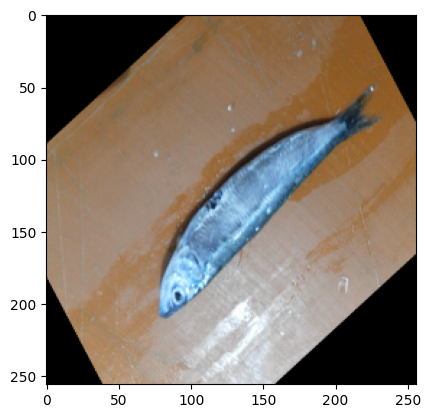

In [13]:
plt.imshow(img[0])

In [14]:
(df['mask'][0])

'/content/drive/MyDrive/Colab_Notebooks/fish/Black Sea Sprat GT/00001.png'

In [15]:
mask = []
for ind in tqdm(range(len(df['mask']))):
    origImage = cv2.imread(df['mask'][ind])
    origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY, )
    origImage = cv2.resize(origImage, (256, 256))
    mask.append((origImage>0.5)**2)
df1['mask'] = mask

100%|██████████| 1000/1000 [00:06<00:00, 152.91it/s]


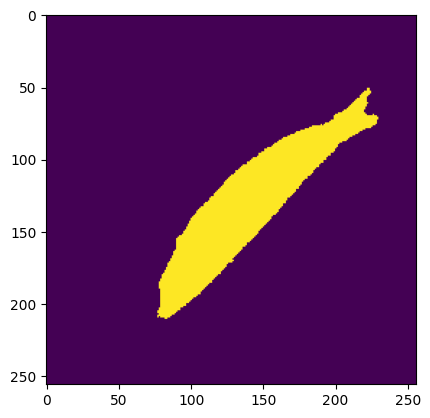

In [16]:
plt.imshow(mask[0])

In [17]:
X_train, X_test = img[:800], img[800:]
y_train, y_test = mask[:800], mask[800:]

In [18]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

class MyDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask.float()

    def __len__(self):
        return len(self.images)

def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Normalize(),
            ToTensorV2()
        ])


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [20]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Assuming MyDataset and get_transform functions are defined elsewhere

# Assuming X_train, y_train, X_test, and y_test are numpy arrays or lists

# Create train and validation datasets
train_dataset = MyDataset(X_train, y_train, get_transform(True))
val_dataset = MyDataset(X_test, y_test, get_transform(True))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# Example usage in training loop
for batch in train_loader:
    images, labels = batch
    # Your training code here

# Example usage in validation loop
for batch in val_loader:
    images, labels = batch
    # Your validation code here


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [21]:
import tqdm
for img,target in tqdm.tqdm(val_loader):
    z = 1

100%|██████████| 50/50 [00:00<00:00, 109.50it/s]


In [22]:
!pip install -U segmentation-models-pytorch albumentations --quiet

1) You task is to solve segmentation task by every possible way. Baseline DICE is 80 (5 p)
<br>2) Each +1% will costs +1p. You can use every possible way except changing input size
  

In [23]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [24]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def total_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dsc = dice_loss(torch.sigmoid(pred), target)
    return bce + dsc

def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    return 1 - dice_loss(preds, targets)


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

from tqdm import tqdm
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = total_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"[Epoch {epoch+1}] Train Loss: {train_loss / len(train_loader):.4f} Dice loss:  {dice_loss(torch.sigmoid(outputs), masks):.4f}")


100%|██████████| 200/200 [00:25<00:00,  7.81it/s]


[Epoch 1] Train Loss: 0.3055 Dice loss:  0.0545


100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


[Epoch 2] Train Loss: 0.0834 Dice loss:  0.0454


100%|██████████| 200/200 [00:14<00:00, 14.12it/s]


[Epoch 3] Train Loss: 0.0701 Dice loss:  0.0449


100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


[Epoch 4] Train Loss: 0.0686 Dice loss:  0.0328


100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


[Epoch 5] Train Loss: 0.0619 Dice loss:  0.0288


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


[Epoch 6] Train Loss: 0.0678 Dice loss:  0.0474


100%|██████████| 200/200 [00:15<00:00, 12.83it/s]


[Epoch 7] Train Loss: 0.0634 Dice loss:  0.0444


100%|██████████| 200/200 [00:14<00:00, 13.76it/s]


[Epoch 8] Train Loss: 0.0568 Dice loss:  0.0241


100%|██████████| 200/200 [00:16<00:00, 12.05it/s]


[Epoch 9] Train Loss: 0.0562 Dice loss:  0.0337


100%|██████████| 200/200 [00:14<00:00, 13.65it/s]

[Epoch 10] Train Loss: 0.0553 Dice loss:  0.0306


In [26]:
model.eval()
val_scores = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        score = dice_score(outputs, masks)
        val_scores.append(score.item())

print(f"Validation DICE: {np.mean(val_scores)*100:.2f}%")


Validation DICE: 88.12%


Teor questions
<br>1) Describe the way to solve image segmentation task without CNN
<br>2) Propose ways to increase quality of classification for imbalance data

Napylov Ivan

1) Describe the way to solve image segmentation task without CNN

Thresholding & Region Growing: Basic methods such as Otsu’s thresholding or iterative region-growing algorithms can separate foreground and background based on pixel intensity or statistical properties.

Graph-Based Segmentation: Techniques like Graph Cut and Watershed transform treat images as graphs, where pixels are nodes and edges represent pixel similarity. These methods excel in partitioning images into coherent regions.


Edge Detection & Clustering: Using Sobel, Canny, or Laplacian filters for edge detection followed by clustering techniques like K-means or Mean Shift can segment images based on intensity gradients.

Active Contours (Snakes): These iterative models adjust curves around object boundaries using energy minimization, making them useful for segmenting smooth contours.

Transform-Based Methods: Wavelet or Gabor filtering can highlight specific spatial features useful for segmentation, especially in medical imaging and texture-based tasks.

Traditional ML Models: Feature extraction followed by classical classifiers (Random Forest, SVM) can work well for segmentation if given carefully engineered features such as texture descriptors or shape-based attributes.



2) Improving Classification for Imbalanced Data
Class imbalance can degrade classification performance, but here are ways to mitigate that:
- Data Resampling: Oversampling minority classes (e.g., SMOTE) or undersampling majority classes balances the dataset.

- Class-Weighing Strategies: Modify loss functions to penalize misclassifications of minority classes more heavily. In deep learning, adjusting

Synthetic Data Generation: Techniques like GANs or variations of augmentation can artificially expand minority class samples.

Ensemble Learning: Combining classifiers trained separately on balanced and imbalanced subsets (e.g., bagging or boosting methods) often improves robustness.

Cost-Sensitive Learning: Adjusting model parameters based on misclassification costs can help focus on minority classes without needing dataset modifications.

Anomaly Detection Approach: In extreme imbalance cases, treating minority class examples as anomalies and leveraging one-class classifiers (e.g., Isolation Forest, Autoencoders) may work well.

